In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as snc
import tqdm 


# Task 4: Bucket FICO scores

Load data

In [2]:
data = pd.read_csv("Task 3 and 4_Loan_Data.csv")
data = data.drop(['customer_id','credit_lines_outstanding',	'loan_amt_outstanding' ,\
                 	'total_debt_outstanding',	'income',	'years_employed'], axis = 1)
data.head()

,fico_score,default
0,605,0
1,572,1
2,602,0
3,612,0
4,631,0


In [3]:
# lets make a column with 5 (arbitrary number of) buckets, dividing our credit data
data['bin'] = pd.cut(data['fico_score'], bins = 5, labels = False)
data.head()

,fico_score,default,bin
0,605,0,2
1,572,1,1
2,602,0,2
3,612,0,2
4,631,0,2


### Let's make a log likelihood function. we will maximize the log likelihood to get the appropriate number of bins and their edges

In [4]:
def log_like(data):
    loglike = 0
    for b in data['bin'].unique():
        bin_data = data[data['bin'] == b]
        if not bin_data.empty:
            nb = len(bin_data)
            kb = bin_data['default'].sum()
            if nb > 0: pb = kb/nb
            else: pb = 0
            loglike += binom.logpmf(kb, nb, pb)
    return loglike


### Now let's find the ideal bin locations for a given dataset by maximizing log likelihood

In [5]:
def optimize_bin_loc(data, nbins, max_runs = 40, verbose = True):
    data['bin'] = pd.cut(data['fico_score'], bins = nbins, labels = False)
    binedges = np.linspace(300, 850, nbins + 1 )
    benchmark_loglike = log_like(data)
    run = 0
    binning_is_improving = True

    while binning_is_improving and run < max_runs:
        binning_is_improving = False
        for edge_id in range(1, nbins):

            #with all other bins fixed, minimize the loglike by changing the position of this one
            for shift in [-10, 10]:
                if binedges[edge_id] >= binedges[edge_id+1] - 10 or binedges[edge_id] <= binedges[edge_id-1] +10 : break
                binedges[edge_id] += shift
                data['bin'] = pd.cut(data['fico_score'], bins = binedges, labels = False)
                shifted_loglike = log_like(data)
                #if we improve the log likelihood, we accept the shift
                if shifted_loglike > benchmark_loglike:
                    binning_is_improving = True
                    benchmark_loglike = shifted_loglike
                else: 
                    binedges[edge_id] -= shift
                    
        
        run +=1
        if verbose == True: print(f'Run {run} : ll = {benchmark_loglike}')
        
    return binedges , data



binedges, processed_data = optimize_bin_loc(data,7)



Run 1 : ll = -16.890277047027887
Run 2 : ll = -15.773875852075395
Run 3 : ll = -15.257681076755404
Run 4 : ll = -13.705901031118385
Run 5 : ll = -13.215918501138557
Run 6 : ll = -12.719149123180316
Run 7 : ll = -12.08374235917038
Run 8 : ll = -11.365801435310832
Run 9 : ll = -10.4998477929406
Run 10 : ll = -9.94578418125031
Run 11 : ll = -9.678351160229816
Run 12 : ll = -9.43214830144965
Run 13 : ll = -9.235441194113577
Run 14 : ll = -8.90407580752061
Run 15 : ll = -8.766377757547854
Run 16 : ll = -8.276642040679837
Run 17 : ll = -8.266943251843932
Run 18 : ll = -8.266943251843932


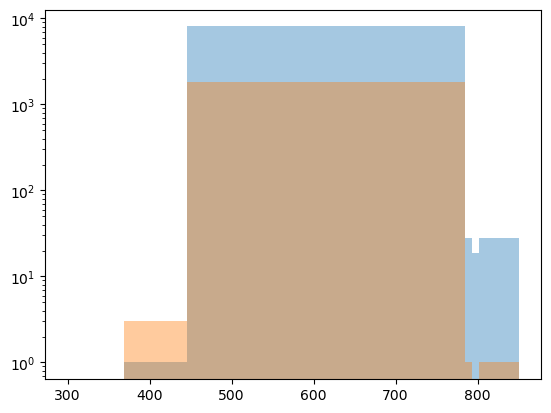

The ideal bin edges are: [300.         368.57142857 437.14285714 445.71428571 784.28571429
 792.85714286 801.42857143 850.        ]


In [6]:
plt.hist((processed_data[processed_data['default'] ==0 ])['fico_score'], bins = binedges, log=True, alpha = 0.4)
plt.hist((processed_data[processed_data['default'] ==1 ])['fico_score'], bins = binedges,log=True, alpha = 0.4 )
plt.show()

print(f'The ideal bin edges are: {binedges}')

Looking at this setup, the middle bin is dominant. However, this means that most customers fall in the middle bin.

In [9]:
def optimize_n_bins_and_loc(data, min_nbins, max_nbins):

    _, data = optimize_bin_loc(data, min_nbins, max_runs = 40, verbose = False)
    benchmark_loglike = log_like(data)

    # increase the number of bins until the log lokeligood stops going up
    for nbins in tqdm.tqdm(range(min_nbins +1 , max_nbins +1)):
        _, data = optimize_bin_loc(data, nbins, max_runs = 40, verbose = False)
        loglike = log_like(data)
        if loglike > benchmark_loglike: 
            benchmark_loglike = log_like(data)
        else: return optimize_bin_loc(data, nbins-1, max_runs = 40, verbose = False)
            

final_bins , final_data =  optimize_n_bins_and_loc(data, 5, 15)
        
        

    

 10%|█         | 1/10 [00:00<00:04,  1.93it/s]


final_bins: [300.         381.66666667 413.33333333 435.         796.66666667
 808.33333333 850.        ]


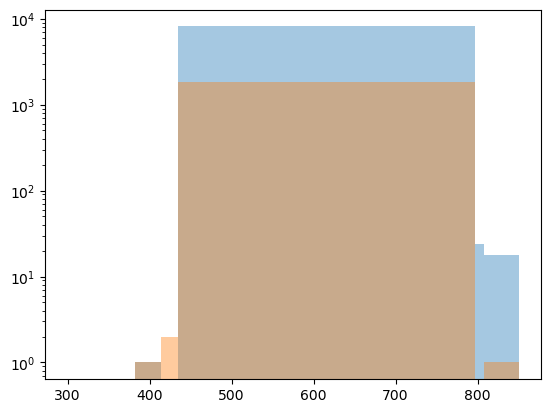

In [10]:
print(f'final_bins: {final_bins}')

plt.hist((final_data[final_data['default'] ==0 ])['fico_score'], bins = final_bins, log=True, alpha = 0.4)
plt.hist((final_data[final_data['default'] ==1 ])['fico_score'], bins = final_bins,log=True, alpha = 0.4 )
plt.show()

The same thing happens when we allow the number of bins to vary.